# Titanic - Machine Learning from Disaster

This data science challenge and corresponding data are found on Kaggle: https://www.kaggle.com/c/titanic/overview 

Here, I'll predict survival on the Titanic. The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.


## Now using Naive Bayes Classifier:

Recall that a classifier is a machine learning model that is used to discriminate different objects based on certain features. A Naive Bayes classifier is a probabilistic machine learning model that's used for classification, and is based on the Bayes Theorem.

Using Bayes theorem, we can find the probability of A happening given that B has occurred. B is the evidence and A is the hypothesis. The assumption is that predictors/features are independent; that is, the presence of one particular feature does not affect the other. This is **Naive**. 



Let's fetch the data and load it:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing: 
These data have already been split into a training and test set. I'll be training the best model I can determine using the training data, and then make predictions on the test data.

In [2]:
TITANIC_train = pd.read_csv('train.csv')
TITANIC_test = pd.read_csv('test.csv')

Taking a look at the training set:

In [3]:
TITANIC_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Most of these data are self-explanatory, but a few are interesting. 

* **Pclass**: passenger class
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic
* **Parch**: how many children & parents of the passenger aboard the Titanic
* **Embarked**: Where the passenger embarked on the Titanic

Get more info on the dataset:

In [4]:
TITANIC_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


How many missing values are present across each variable?

In [5]:
TITANIC_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Okay good to know! 177 missing values in the age category, and 687 in the cabin category. 

I'm now going to take a look at the categorical attributes:

In [6]:
TITANIC_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [7]:
TITANIC_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
TITANIC_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

C = Cherbourg, Q = Queenstown, S = Southampton

### Building some Pipelines now to make preprocessing easy: 

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder #to handle categorical attributes
from sklearn.preprocessing import StandardScaler # to handle missing values in numerical attributes

To handle missing values for numerical attributes. Here I'm replacing missing with the median:

In [10]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

To encode categorical attributes:

In [11]:
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

#### Join the numerical and categorical pipelines:

The numerical attributes I'm interested in using to build a model to predict survival include **Age**, **SibSp**, **Parch**, and **Fare**. The categorical attributes I'm interested in using to build a model to predict survival include **Pclass**, **Sex**, and **Embarked**

In [12]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Now creating a new variable where I use the pipeline and transform the training dataset:

In [13]:
# Not including the dependent variable here, only the num_attribs and cat_attribs:
X_train = preprocess_pipeline.fit_transform(
    TITANIC_train[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

The test set needs to go through the same preprocessing pipeline. 

In [14]:
X_test = preprocess_pipeline.fit_transform(
    TITANIC_test[num_attribs + cat_attribs])

#### Grab the Dependent/Predicted Variable:

In [15]:
y_train = TITANIC_train["Survived"]

#### I'm going to try the Naive Bayes Model:

In [16]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [17]:
# fit the model on the training data
model.fit(X_train, y_train)

GaussianNB()

And now make predictions:

In [18]:
y_pred = model.predict(X_test)

Use cross-validation to see how good the model is:

In [19]:
from sklearn.model_selection import cross_val_score

model_scores = cross_val_score(model, X_train, y_train, cv=10)
model_scores.mean()

0.7856803995006241

## Accuracy of about 79! Let's see a spread of this in a box plot: 

In [20]:
model_scores

array([0.74444444, 0.73033708, 0.78651685, 0.80898876, 0.79775281,
       0.7752809 , 0.79775281, 0.79775281, 0.78651685, 0.83146067])

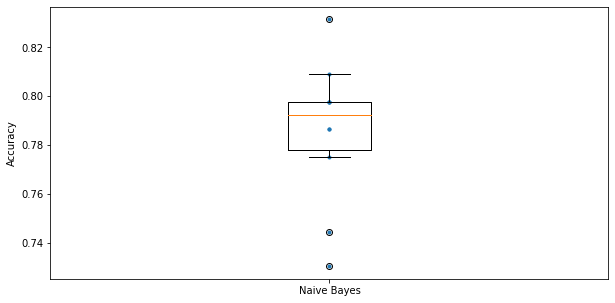

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot([1]*10,model_scores, ".")

plt.boxplot([model_scores],labels = None)
plt.ylabel("Accuracy")
plt.xticks([1], ['Naive Bayes'])
plt.show()